### Predict the number of hikers at a given date

In [3]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from xgboost import XGBRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../data/trails-weather-clean.csv', index_col=[0])

In [5]:
traindf = df.copy()

# Preprocessing
traindf['date'] = pd.to_datetime(traindf['date'])
traindf['day_of_week'] = traindf['date'].dt.dayofweek
traindf['is_weekend'] = traindf['day_of_week'] >= 5

# Separate the target variable before encoding and scaling
y = traindf['count']

# Drop unnecessary columns
X = traindf.drop(['count', 'date', 'year', 'location', 'trail', 'week'], axis=1)

# Encode categorical variables and scale numerical features
categorical_features = ['site', 'season', 'is_weekend']

# numerical_features = ['TMAX', 'TMIN', 'TAVG', 'WDF2', 'WT07', 'WDF5', 'WSF2', 'WSF5'] --> better results without scaling weather data
numerical_features = ['total_previous_week',
       'total_previous_month', 'total_previous_year',
       'amount_same_day_last_week', 'amount_same_day_last_month',
       'amount_same_day_last_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MaxAbsScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# XGBoost Regressor
xgb = XGBRegressor()

# Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', xgb)])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameters
param_distributions = {
    'model__learning_rate': [0.1],
    'model__n_estimators': [100],
    'model__max_depth': [2],
    'model__min_child_weight': [5],
    'model__gamma':[0],
    'model__subsample': [0.8],
    'model__colsample_bytree':[0.8],
    'model__scale_pos_weight': [1],
    'model__seed': [27],
    'model__reg_alpha':[100]
}

search = GridSearchCV(pipeline, param_distributions, cv=tscv)

# 80% train, 20% test
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit
search.fit(X_train, y_train)

# Test
y_pred = search.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R-squared on Test Set: {r2}')
print(f'RSME on Test Set: {int(np.sqrt(mse))}')

# Testing diffferent scalers:
# Mean Squared Error on Test Set for MaxAbsScaler: 36790.479287030146
# R-squared on Test Set for MaxAbsScaler: 0.6285699135248608 

# Mean Squared Error on Test Set for MinMaxScaler: 36790.479287030146
# R-squared on Test Set for MinMaxScaler: 0.6285699135248608 

# Mean Squared Error on Test Set for Normalizer: 49320.743517643845
# R-squared on Test Set for Normalizer: 0.5020666111236356 

# Mean Squared Error on Test Set for PowerTransformer: 37155.761449051075
# R-squared on Test Set for PowerTransformer: 0.6248820902712211 

# Mean Squared Error on Test Set for QuantileTransformer: 36925.306072225605
# R-squared on Test Set for QuantileTransformer: 0.6272087264608487 

# Mean Squared Error on Test Set for RobustScaler: 36877.34333842338
# R-squared on Test Set for RobustScaler: 0.627692949626977 

# Mean Squared Error on Test Set for StandardScaler: 37155.761449051075
# R-squared on Test Set for StandardScaler: 0.6248820902712211 

Mean Squared Error on Test Set: 36790.479287030146
R-squared on Test Set: 0.6285699135248608
RSME on Test Set: 191


### Retest by replacing outliers in the data with the min() max() of non-outliers

In [6]:
d = df.copy()

def replace_outliers(sitename):
    global d
    df_site = d[d['site'] == sitename]
    
    Q1 = df_site['count'].quantile(0.25)
    Q3 = df_site['count'].quantile(0.75)
    IQR = Q3 - Q1
    upper_outlier = Q3 + 1.5 * IQR
    lower_outlier = Q1 - 1.5 * IQR
    
    # Get the max and min not including outliers
    non_outlier_max = df_site[df_site['count'] < upper_outlier]['count'].max()
    non_outlier_min = df_site[df_site['count'] > lower_outlier]['count'].min()
    
    # Replace outliers
    d.loc[(d['site'] == sitename) & (d['count'] < lower_outlier), 'count'] = non_outlier_min
    d.loc[(d['site'] == sitename) & (d['count'] > upper_outlier), 'count'] = non_outlier_max

sites = d['site'].unique().tolist()
for site in sites:
    replace_outliers(site)

d = d.fillna(0)

In [7]:
traindf = d.copy()

# Preprocessing
traindf['date'] = pd.to_datetime(traindf['date'])
traindf['day_of_week'] = traindf['date'].dt.dayofweek
traindf['is_weekend'] = traindf['day_of_week'] >= 5

# Separate the target variable before encoding and scaling
y = traindf['count']

# Drop unnecessary columns
X = traindf.drop(['count', 'date', 'year', 'location', 'trail', 'week'], axis=1)

# Encode categorical variables and scale numerical features
categorical_features = ['site', 'season', 'is_weekend']

# numerical_features = ['TMAX', 'TMIN', 'TAVG', 'WDF2', 'WT07', 'WDF5', 'WSF2', 'WSF5'] --> better results without scaling the temps
numerical_features = ['total_previous_week',
       'total_previous_month', 'total_previous_year',
       'amount_same_day_last_week', 'amount_same_day_last_month',
       'amount_same_day_last_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MaxAbsScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# XGBoost Regressor
xgb = XGBRegressor()

# Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', xgb)])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameters
param_distributions = {
    'model__learning_rate': [0.1],
    'model__n_estimators': [100],
    'model__max_depth': [2],
    'model__min_child_weight': [5],
    'model__gamma':[0],
    'model__subsample': [0.8],
    'model__colsample_bytree':[0.8],
    'model__scale_pos_weight': [1],
    'model__seed': [27],
    'model__reg_alpha':[100]
}

search = GridSearchCV(pipeline, param_distributions, cv=tscv)

# 80% train, 20% test
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit
search.fit(X_train, y_train)

# Test
y_pred = search.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R-squared on Test Set: {r2}')
print(f'RSME on Test Set: {int(np.sqrt(mse))}')

Mean Squared Error on Test Set: 19450.191300011793
R-squared on Test Set: 0.7553082465145817
RSME on Test Set: 139


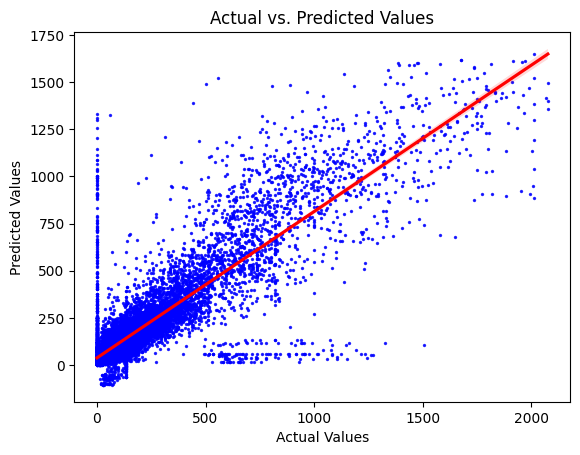

In [8]:
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 2, 'color': 'blue'}, line_kws={'color': 'red'})

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()
